In [1]:
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from salishsea_tools import metric_tools_5x5 as met

%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

3

In [2]:
# Parent directory for the results of this run
group_results_directory = '/data/jpetrie/MEOPAR/SalishSea/results/nampisrem_old_IC_june_16/' + '/'
tracer_file = 'SS5x5_1h_20150201_20150501_ptrc_T.nc'
mesh_mask_file = 'mesh_mask.nc'
individual_directories = []
param_vals = []
param_name = "nampisrem_zz_remin_nh"

for file in os.listdir(group_results_directory):
    if os.path.isfile(group_results_directory + file + '/' + tracer_file):
        last_underscore = file.rfind("_")
        file_param_name = file[:last_underscore]
        if file_param_name == param_name:
            val = float(file[(last_underscore + 1):])
            individual_directories.append(file)
            param_vals.append(val)

tracer_datasets = [xr.open_dataset(group_results_directory + '/' + file +'/' + tracer_file) for file in individual_directories]
dataset_dict = dict(zip(param_vals, tracer_datasets))

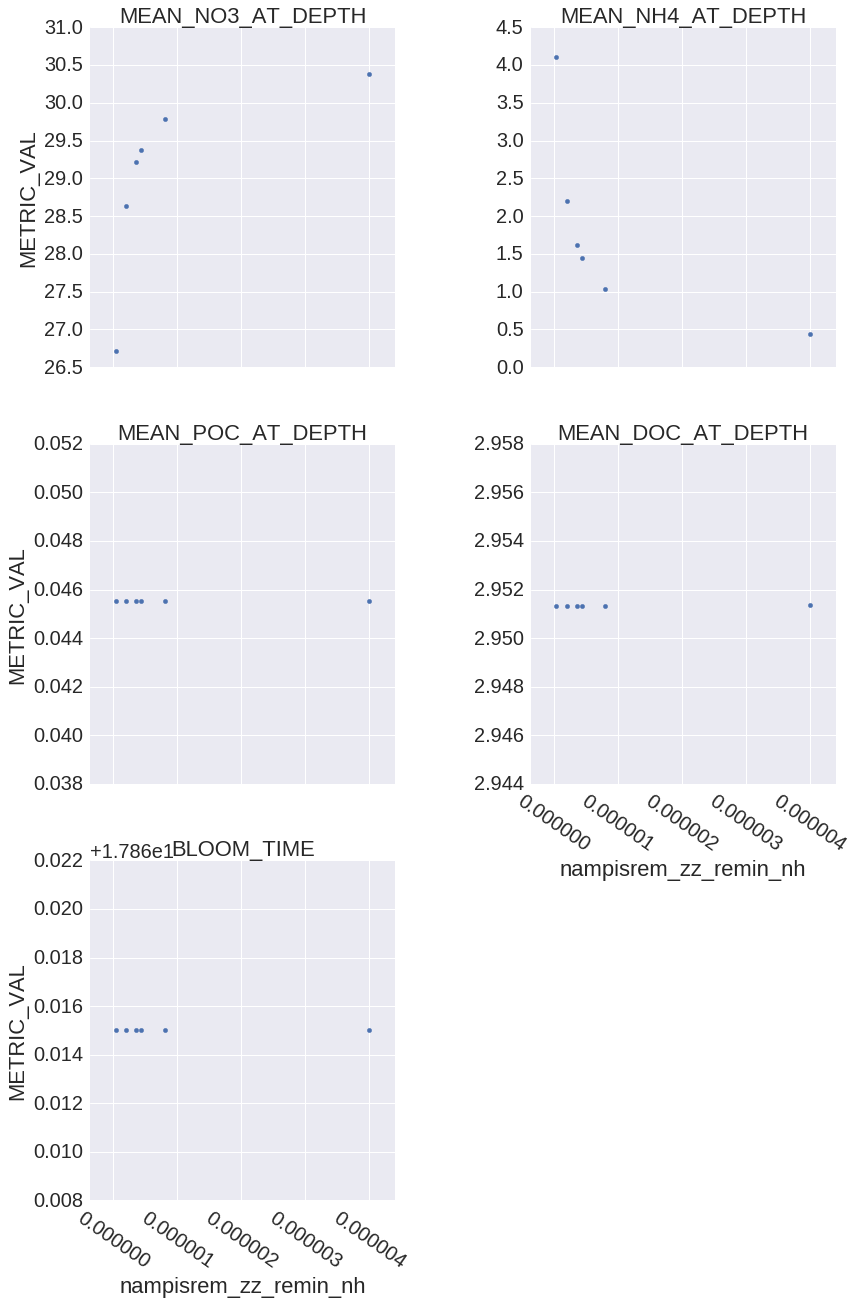

In [3]:
plot_tracers = ['NO3', 'NH4', 'POC', 'DOC']

param_metrics = pd.DataFrame()
for param in param_vals:
    for tracer in plot_tracers:
        mean_tracer = met.mean_tracer_at_depth(dataset_dict[param], tracer)
        param_metrics = param_metrics.append(pd.DataFrame({param_name:[param], "METRIC_NAME":['MEAN_'+tracer + "_AT_DEPTH"], "METRIC_VAL": [mean_tracer]}))
    bloom_time = met.time_surface_NO3_drops_below_4(dataset_dict[param])
    param_metrics = param_metrics.append(pd.DataFrame({param_name:[param], "METRIC_NAME":["BLOOM_TIME"], "METRIC_VAL": [bloom_time]}))

   
sns.set(font_scale = 2)
plt.rcParams['image.cmap'] = 'jet'

fg = sns.FacetGrid(data=param_metrics, col = "METRIC_NAME",  sharey=False, col_wrap = 2, size = 6)
fg.set(xlim=(min(param_metrics[param_name]) - 0.1*max(param_metrics[param_name]),1.1*max(param_metrics[param_name])))
fg.map(plt.scatter, param_name, "METRIC_VAL").add_legend()
fg.set_xticklabels(rotation=-35)
fg.set_titles("{col_name}")

In [4]:
def plot_tracer_heatmaps(dataset_dict, tracer, vmin = None, vmax = None):
    plt.rcParams['image.cmap'] = 'jet'
    keys = (list(dataset_dict.keys()))
    keys.sort()

    for param_val in keys:
        z = dataset_dict[param_val].deptht.values
        t= np.array([float(x) for x in dataset_dict[param_val].time_centered.values])
        tz,zt=np.meshgrid((t[:] - t[0])/10**9/3600/24,z[:])

        fig, ax = plt.subplots(1, 1,figsize=(10,4))
        
        mesh=plt.pcolormesh(tz,zt,dataset_dict[param_val][tracer].values[:,:,2,2].T, vmin = vmin, vmax = vmax)
        fig.colorbar(mesh)
        plt.gca().invert_yaxis()
        plt.title(tracer +  " (" + param_name + " = " + str(param_val)+")", size = 20)
        plt.xlabel("Days", size =18)
        plt.ylabel("Depth", size = 18)
        
def plot_tracer_dif_heatmap(dataset_dict, tracer):
    param_vals = list(dataset_dict.keys())
    param_1 = min(param_vals)
    param_2 = max(param_vals)
    
    z = dataset_dict[param_1].deptht.values
    t= np.array([float(x) for x in dataset_dict[param_1].time_centered.values])
    tz,zt=np.meshgrid((t[:] - t[0])/10**9/3600/24,z[:])
    
    fig, ax = plt.subplots(1, 1,figsize=(15,6))
    mesh=plt.pcolormesh(tz,zt,dataset_dict[param_1][tracer].values[:,:,2,2].T - dataset_dict[param_2][tracer].values[:,:,2,2].T)
    fig.colorbar(mesh)
    plt.gca().invert_yaxis()
    plt.xlabel("Days", size =18)
    plt.ylabel("Depth", size = 18)
    plt.title(tracer + " difference (" + param_name + "=" + str(param_1) + " - " + param_name + "=" +str(param_2)+ ")")


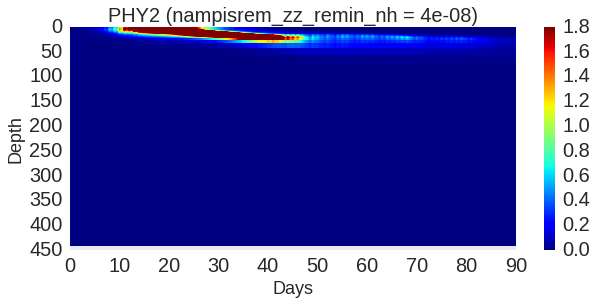

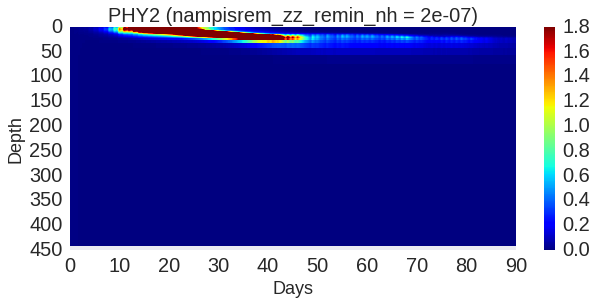

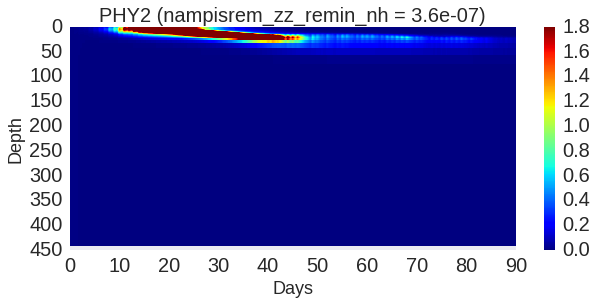

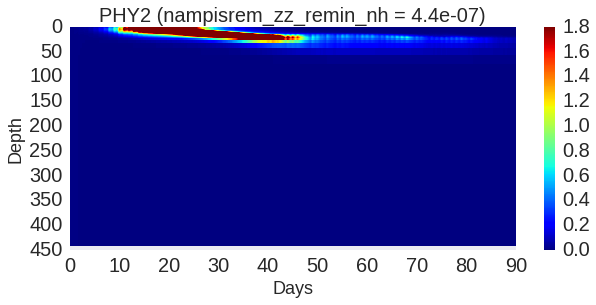

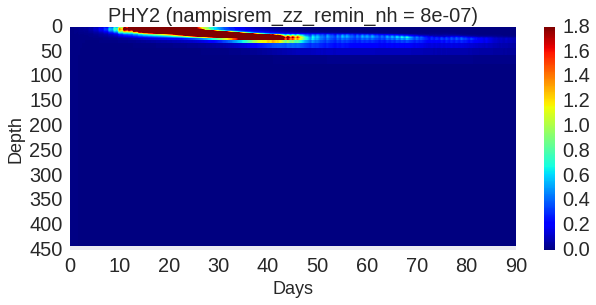

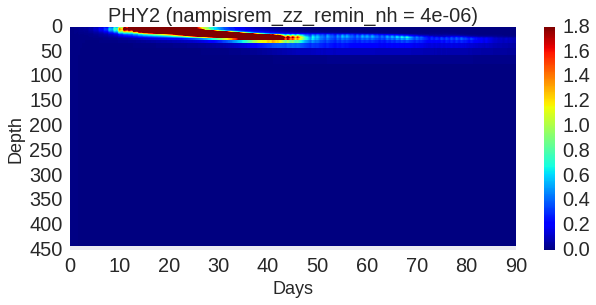

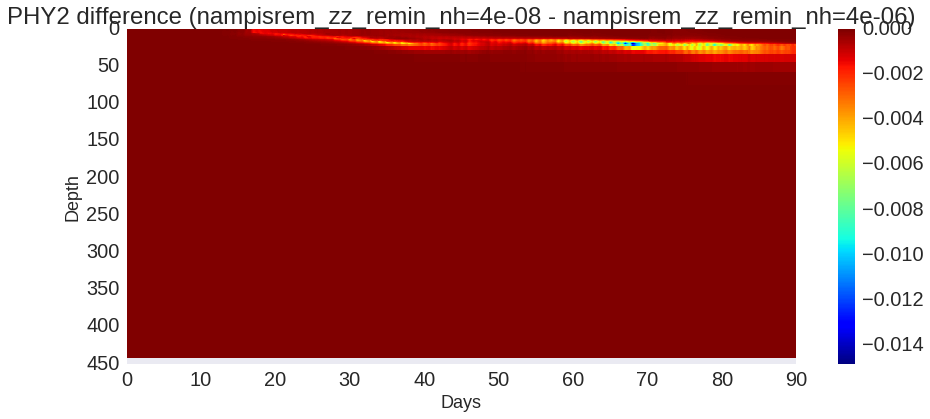

In [5]:
plot_tracer_heatmaps(dataset_dict, "PHY2", 0, 1.8)
plot_tracer_dif_heatmap(dataset_dict, "PHY2")

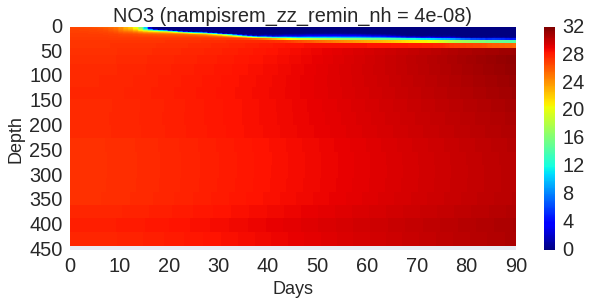

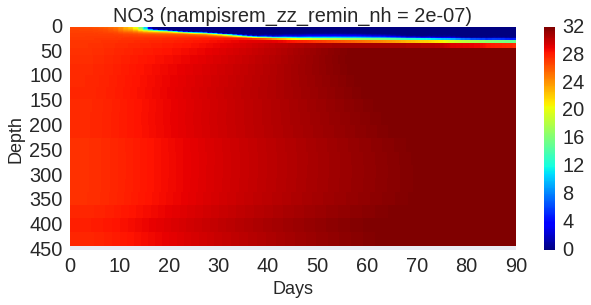

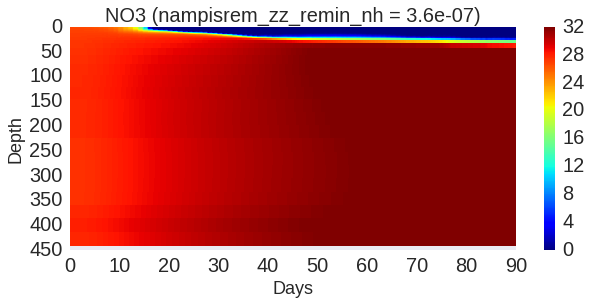

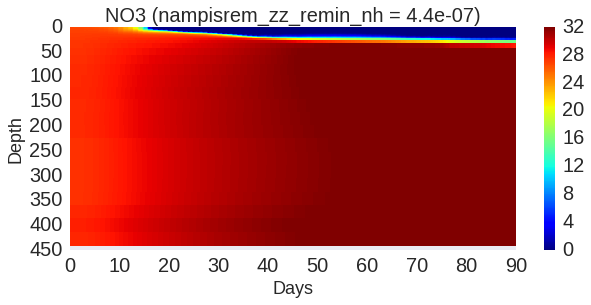

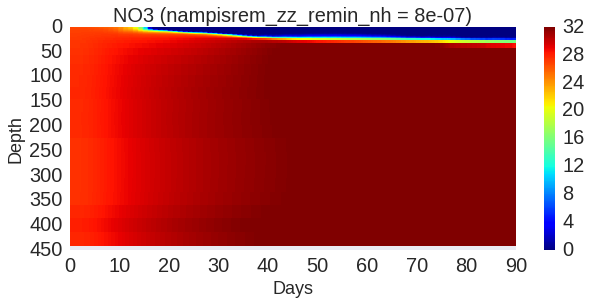

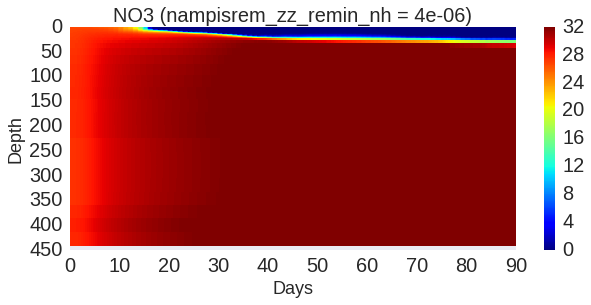

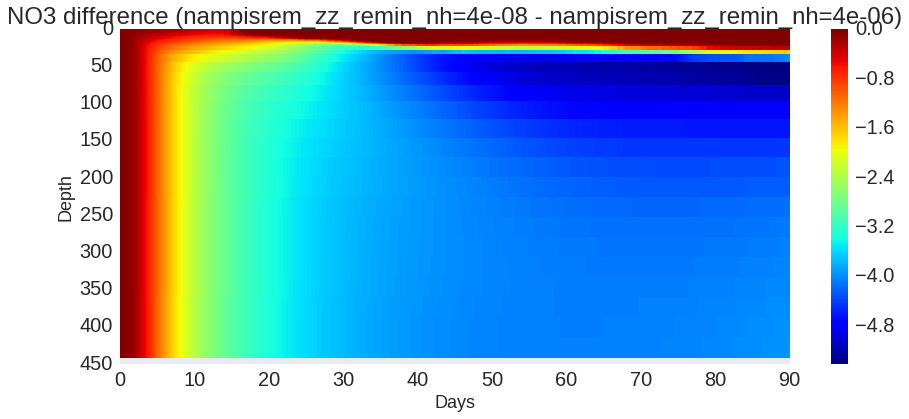

In [6]:
plot_tracer_heatmaps(dataset_dict, "NO3", 0, 32)
plot_tracer_dif_heatmap(dataset_dict, "NO3")

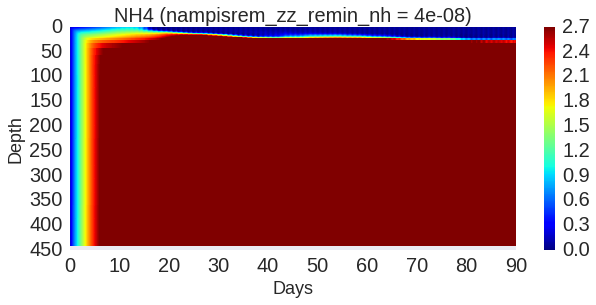

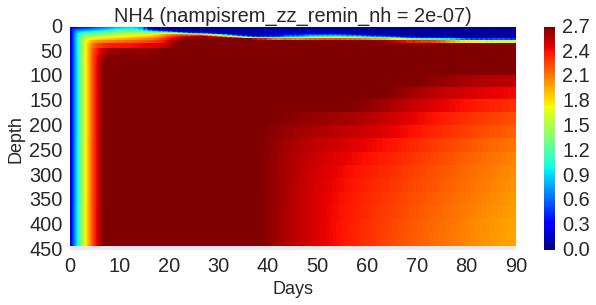

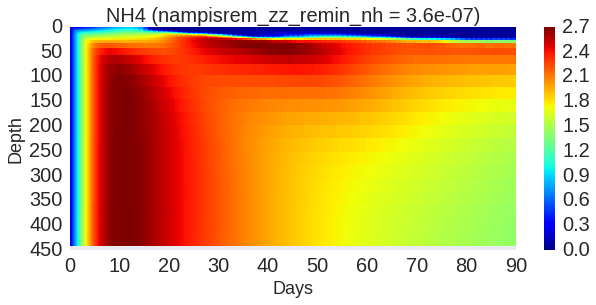

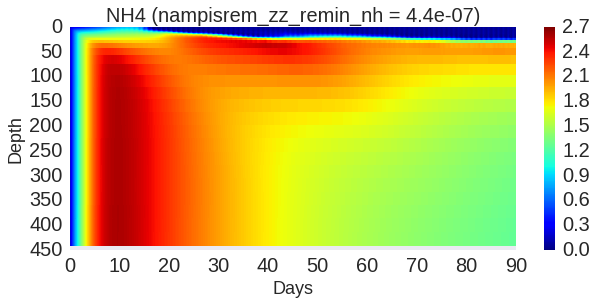

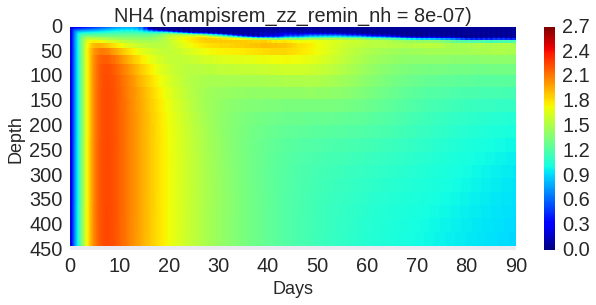

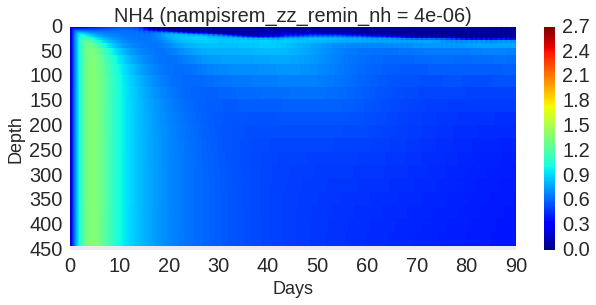

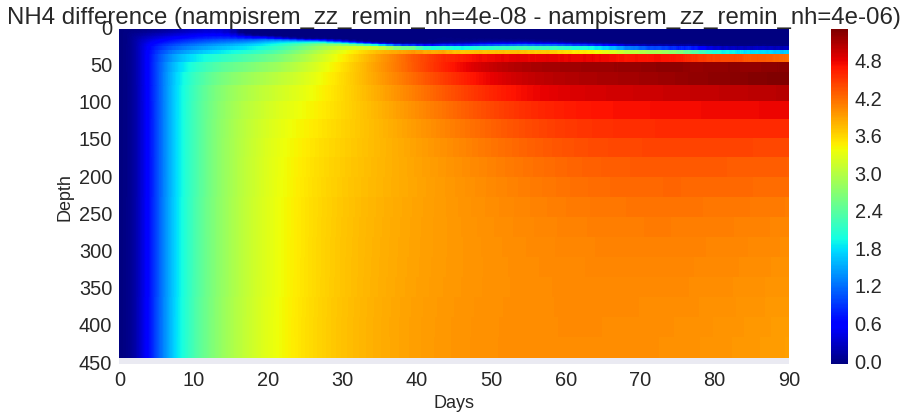

In [7]:
plot_tracer_heatmaps(dataset_dict, "NH4", 0, 2.7)
plot_tracer_dif_heatmap(dataset_dict, "NH4")

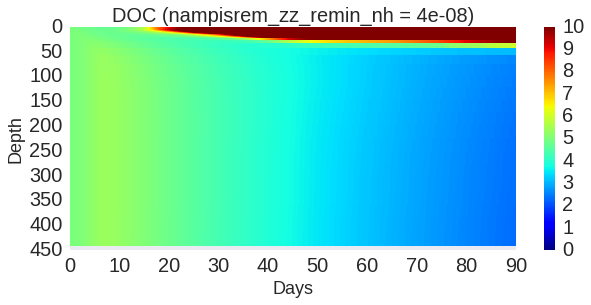

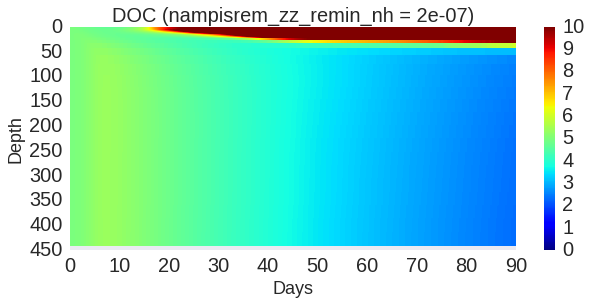

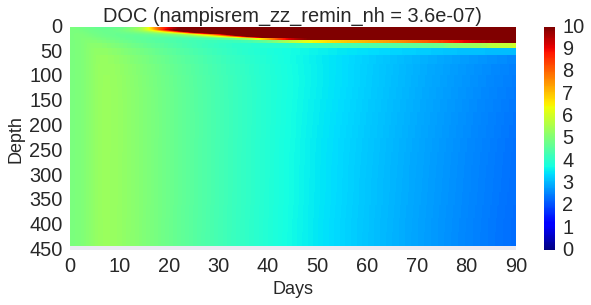

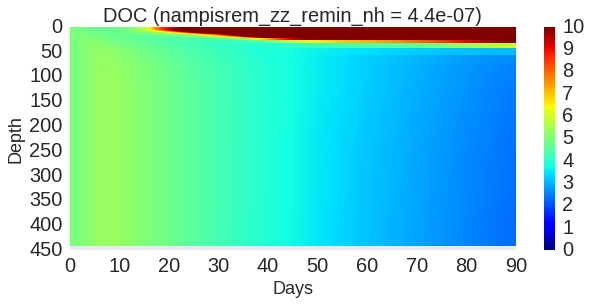

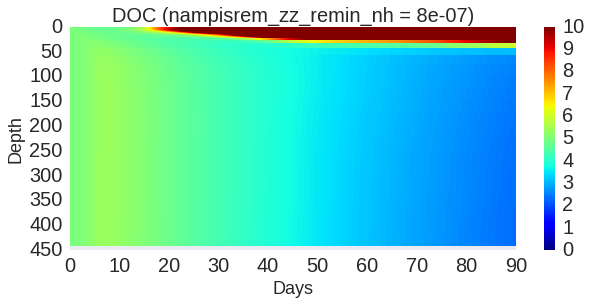

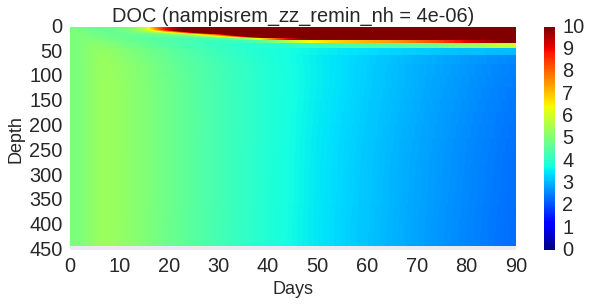

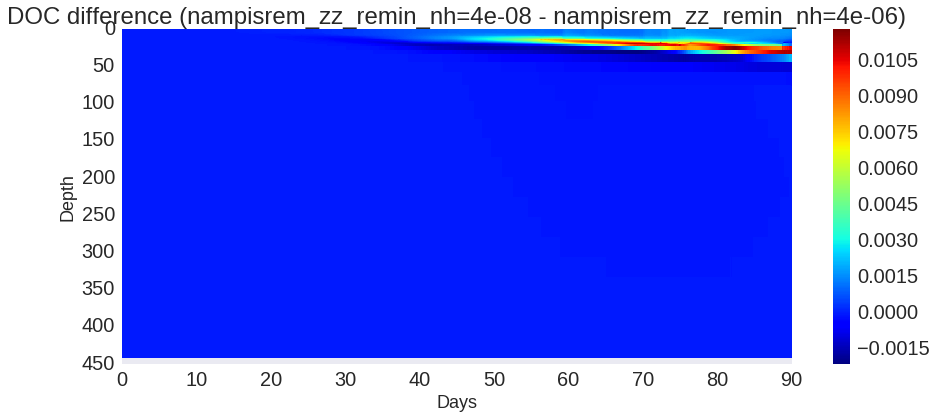

In [8]:
plot_tracer_heatmaps(dataset_dict, "DOC", 0, 10)
plot_tracer_dif_heatmap(dataset_dict, "DOC")

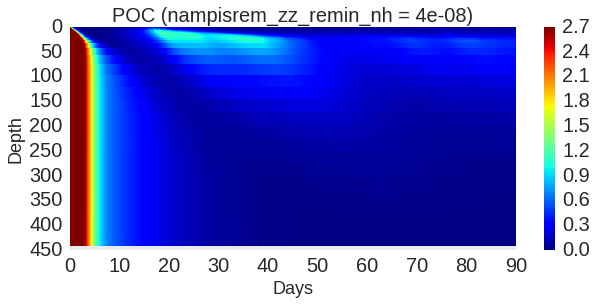

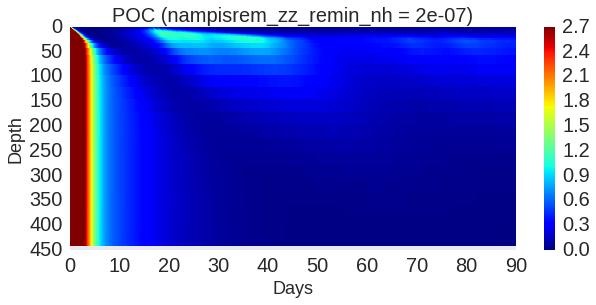

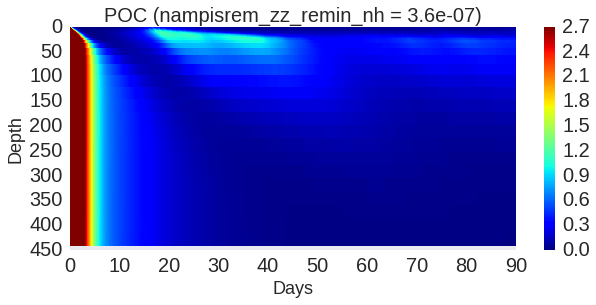

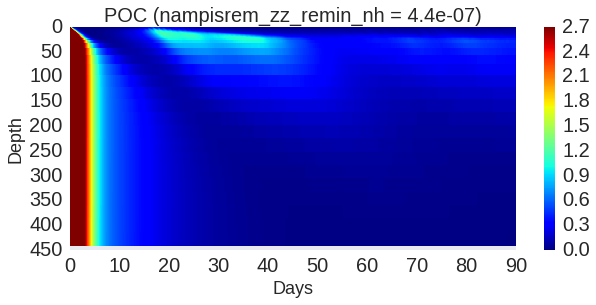

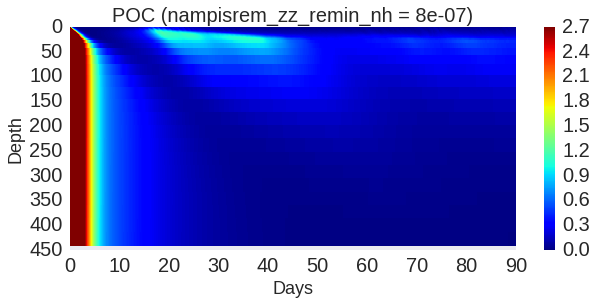

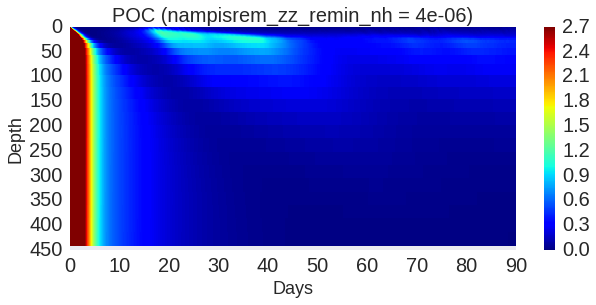

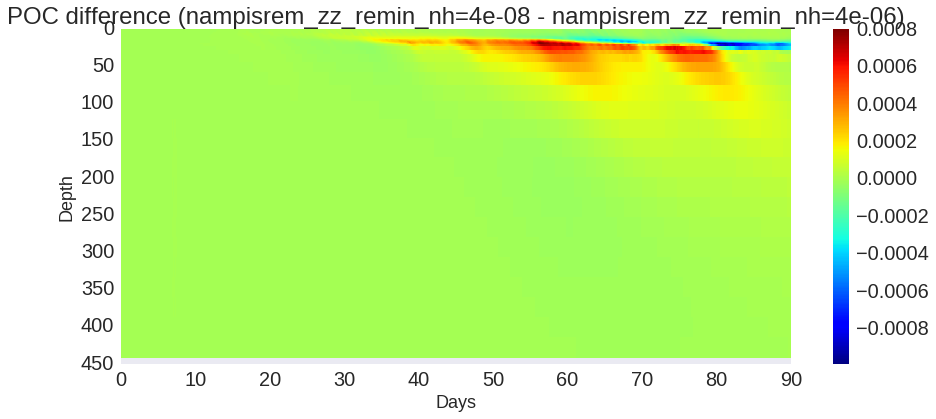

In [9]:
plot_tracer_heatmaps(dataset_dict, "POC", 0, 2.7)
plot_tracer_dif_heatmap(dataset_dict, "POC")

In [10]:
# Convert list of xarrays to a single pandas dataframe
keys = (list(dataset_dict.keys()))
keys.sort()

dataframe_list = []
for param_val in keys:
    df = dataset_dict[param_val].to_dataframe().query('x == 2 and y == 2 and axis_nbounds == 0')
    df[param_name] = param_val
    dataframe_list.append(df)

df_subset = pd.concat(dataframe_list)

df_subset.reset_index(inplace=True) # Get rid of that multiindex madness

In [11]:
plot_vars = ['PHY', 'PHY2','MICZ', 'MYRI', 'NO3', 'NH4', 'DOC', 'POC', 'Si', 'bSi', 'O2']

[   0.5000003    15.63428783   98.06295776  306.834198  ]


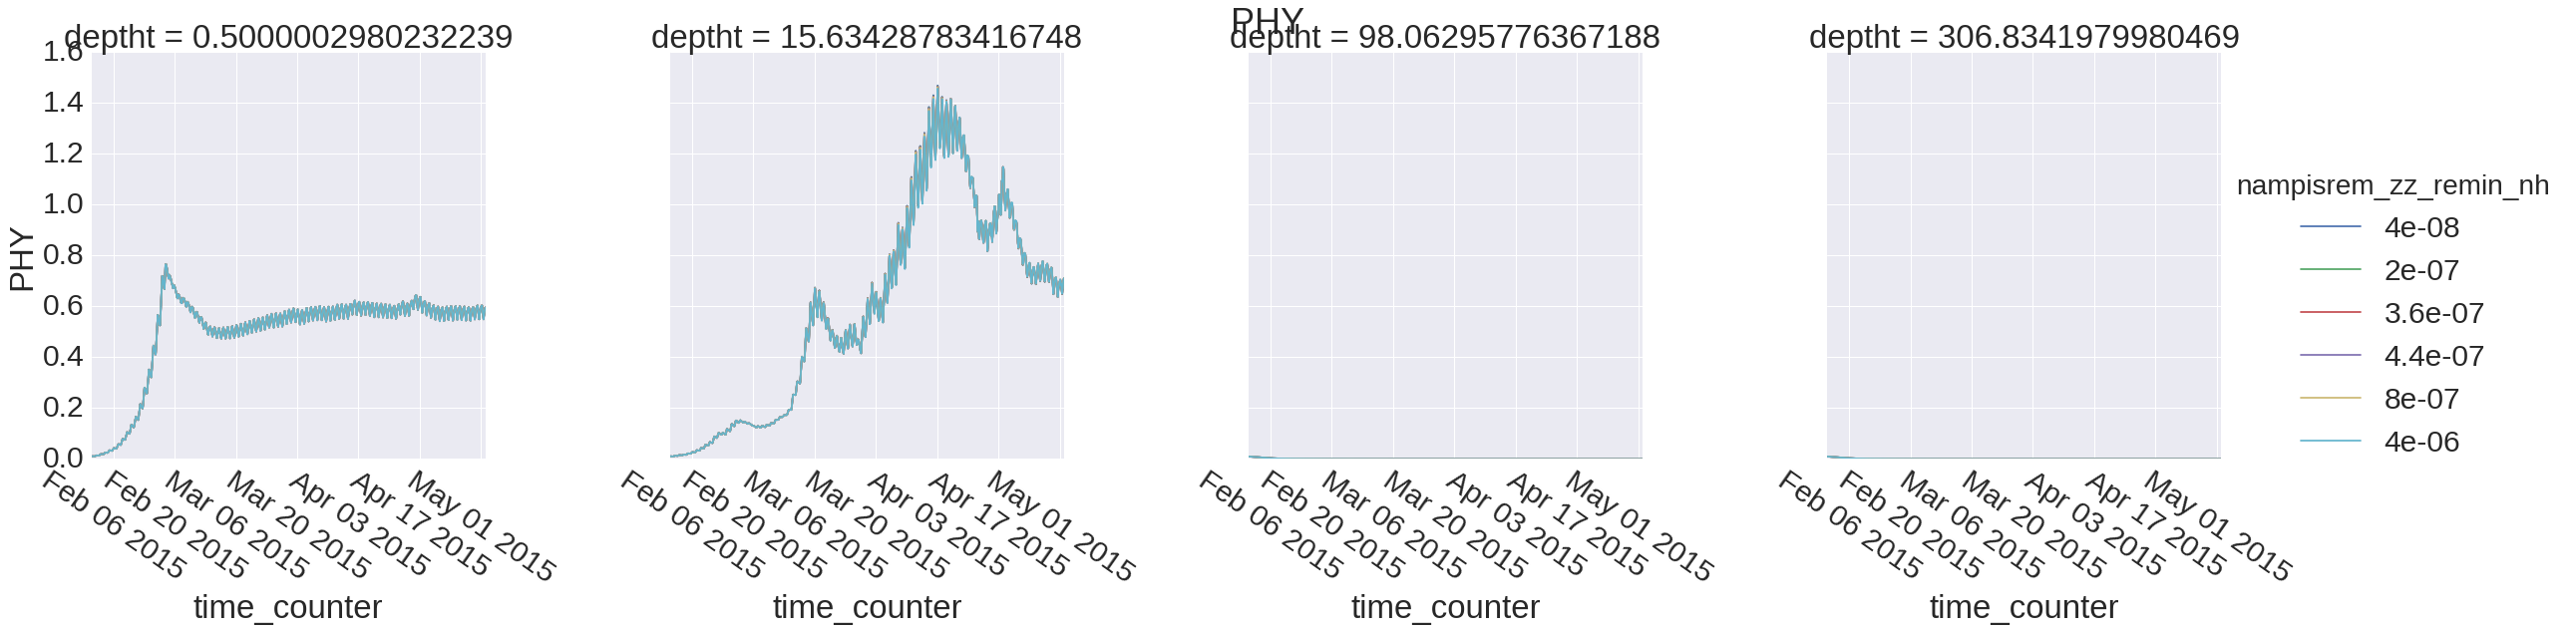

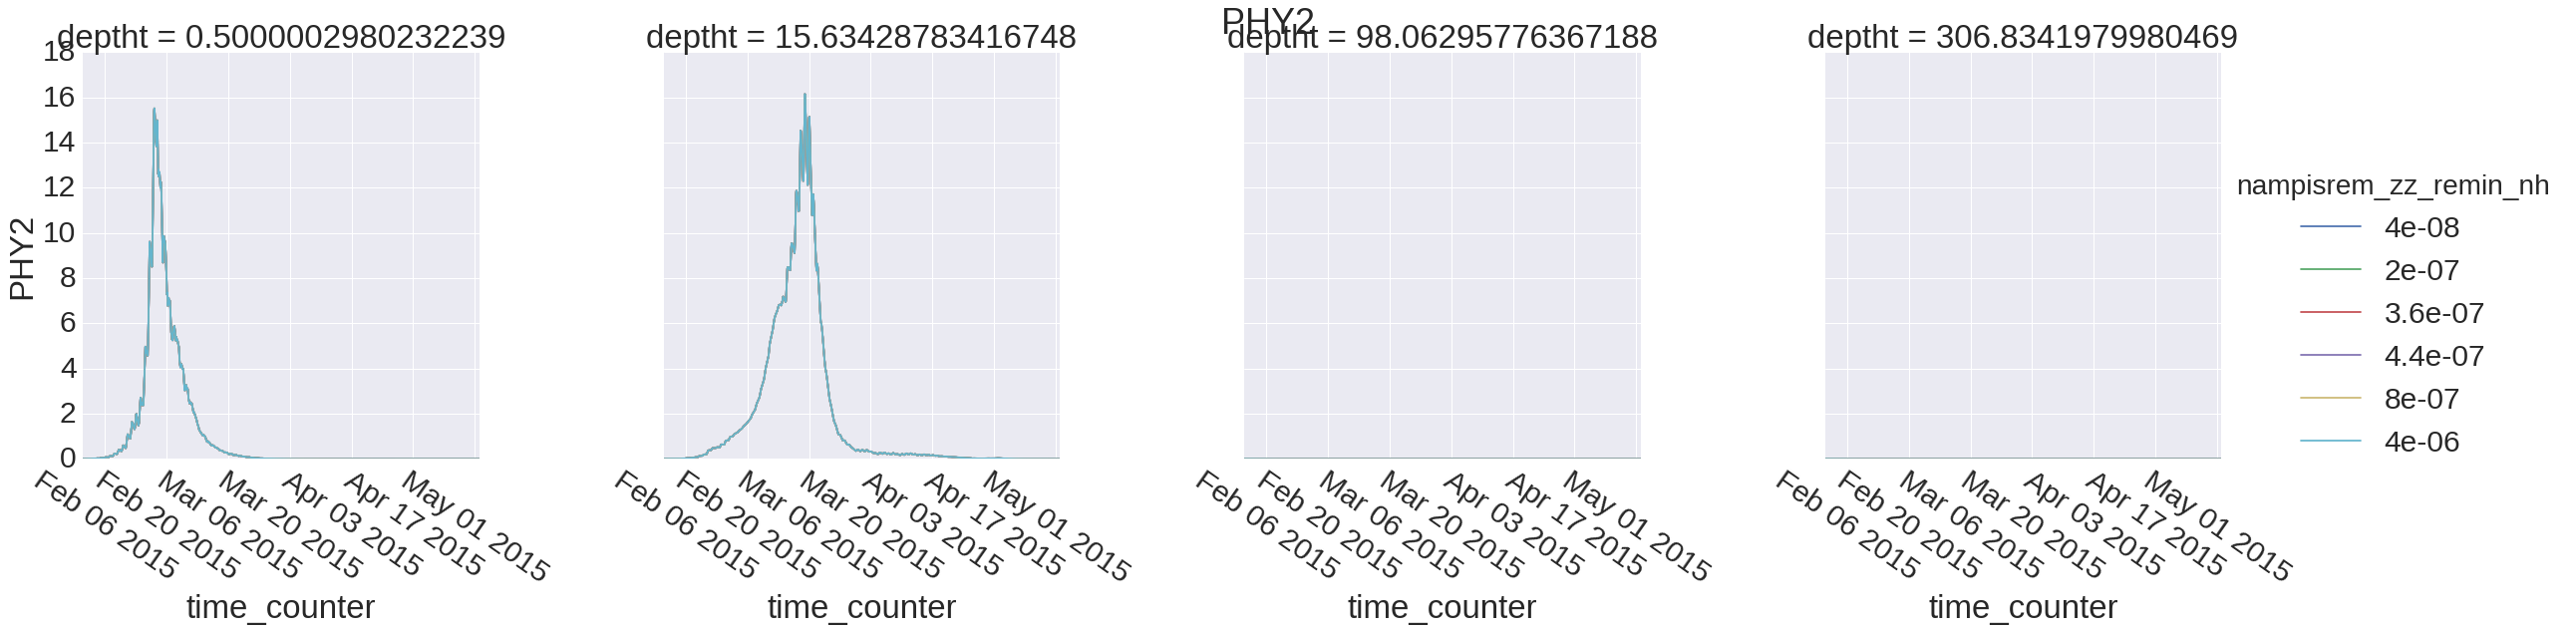

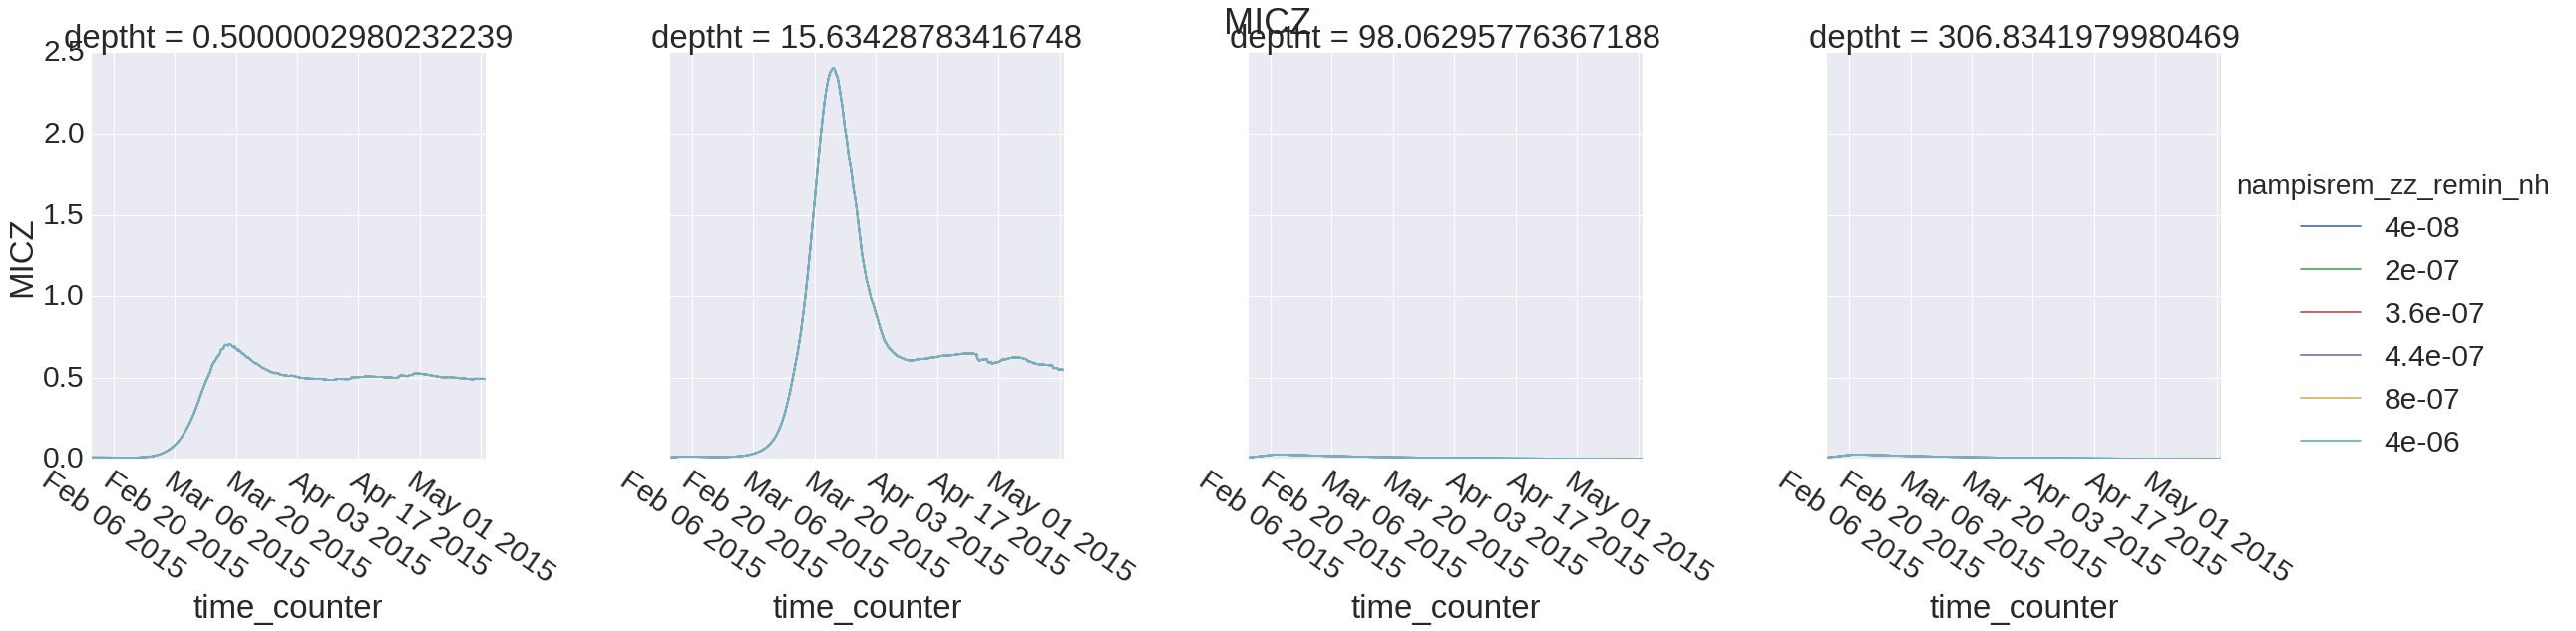

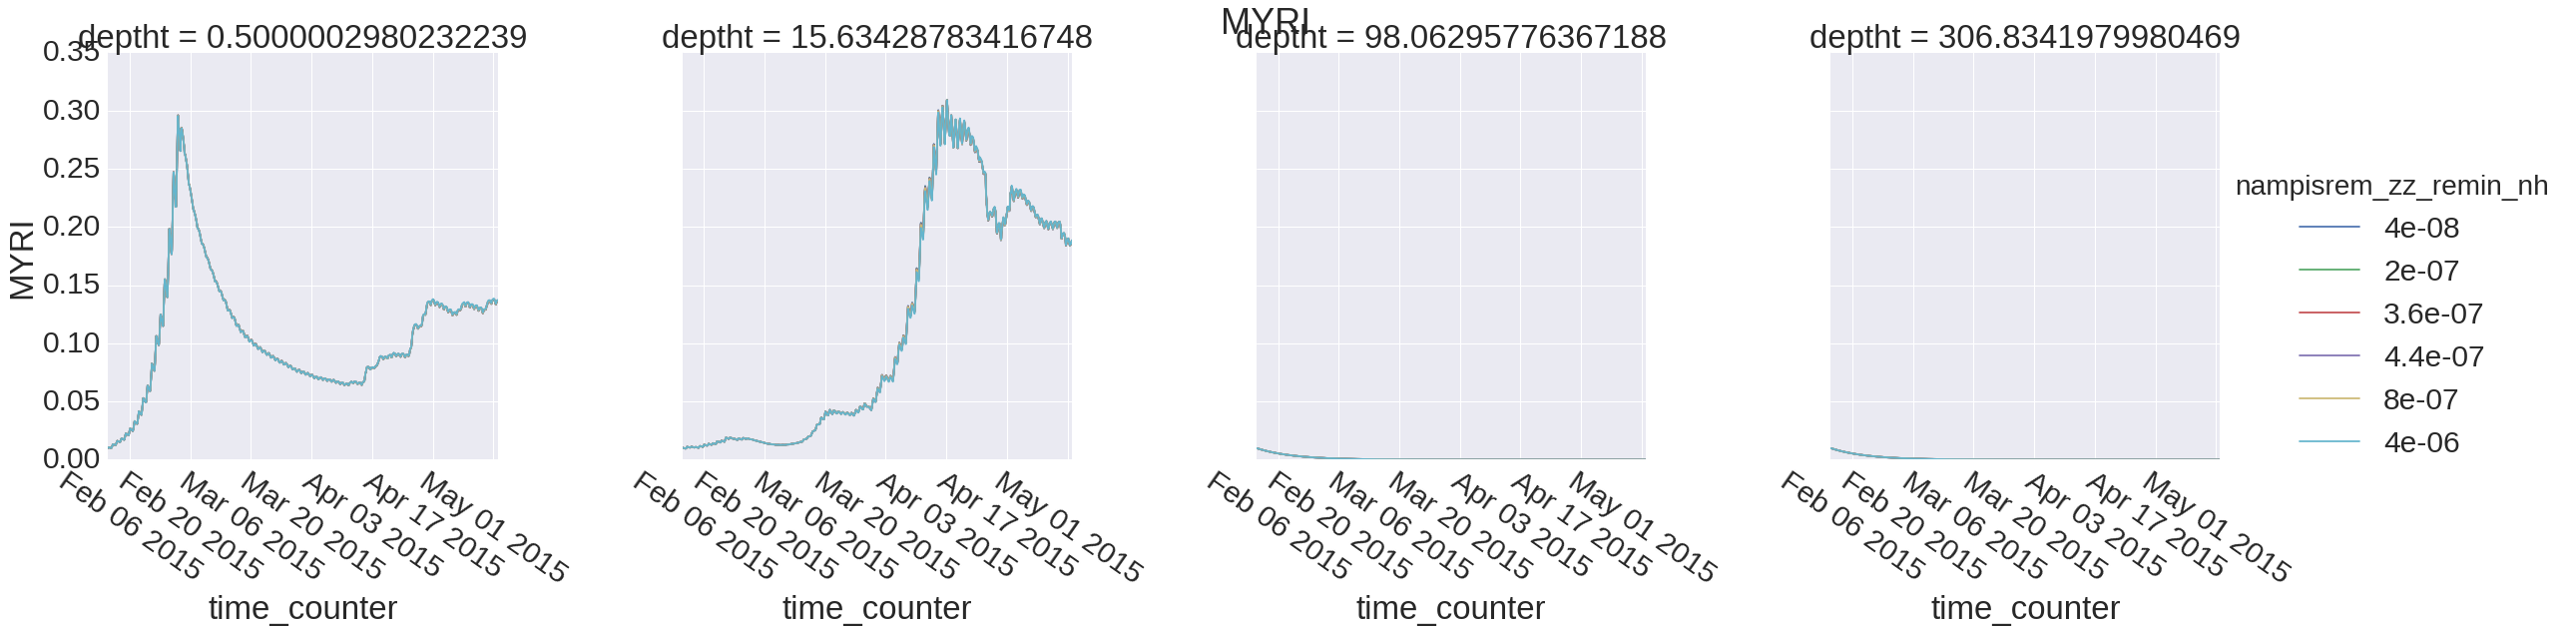

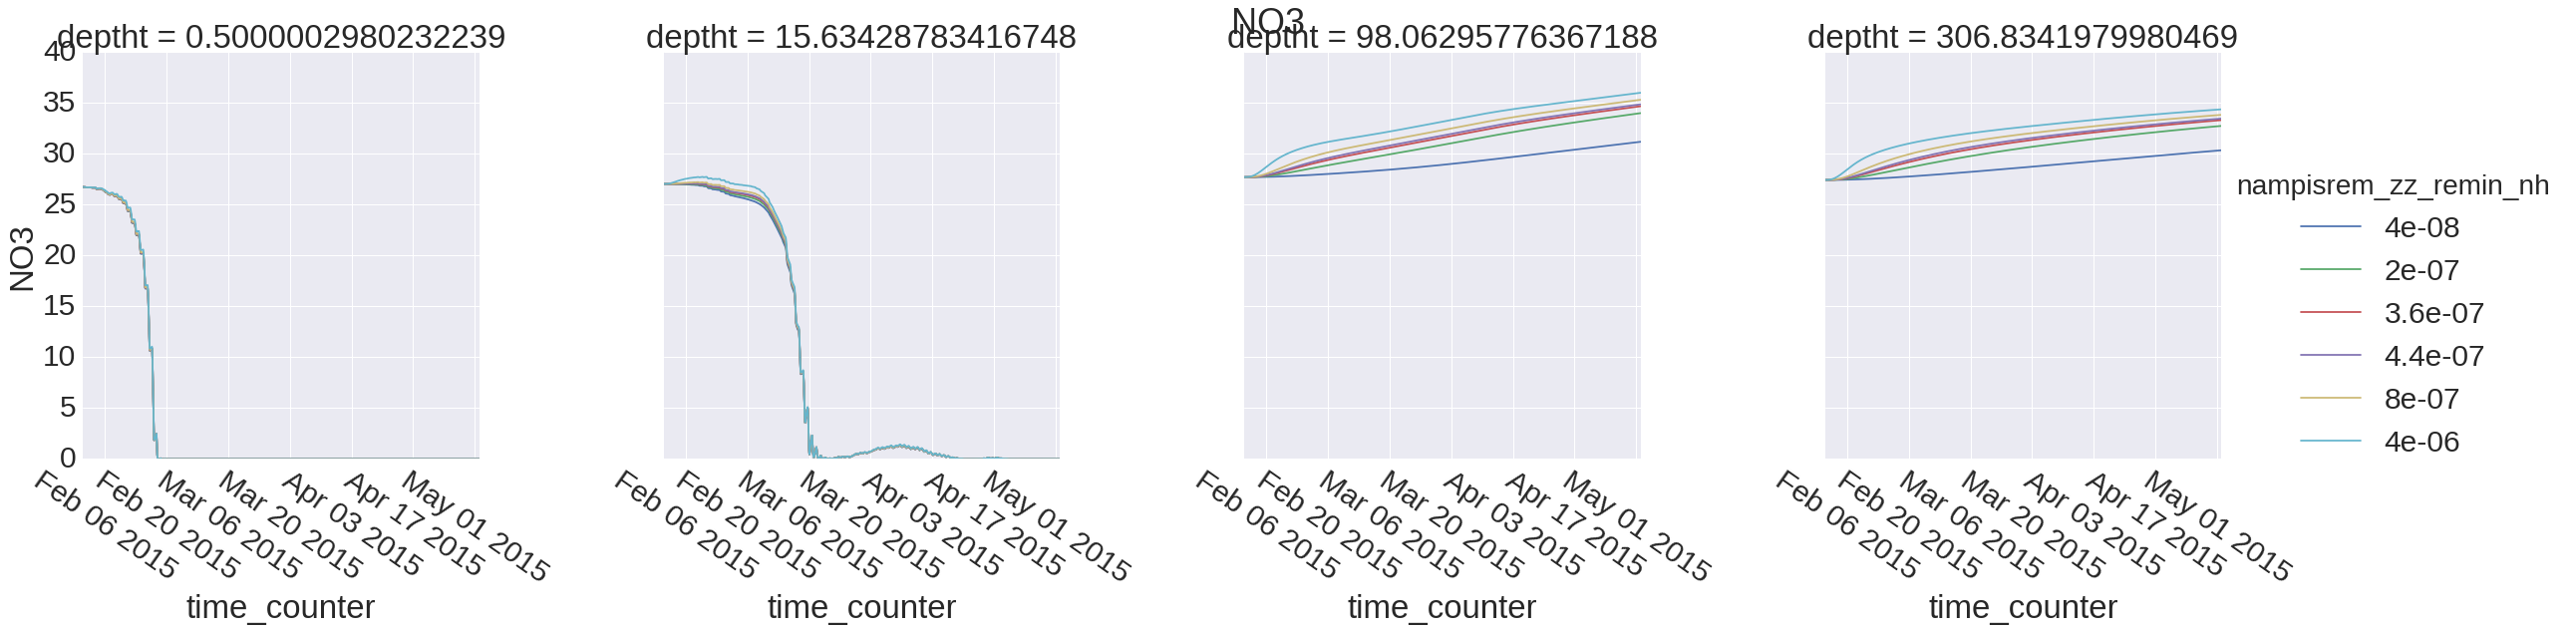

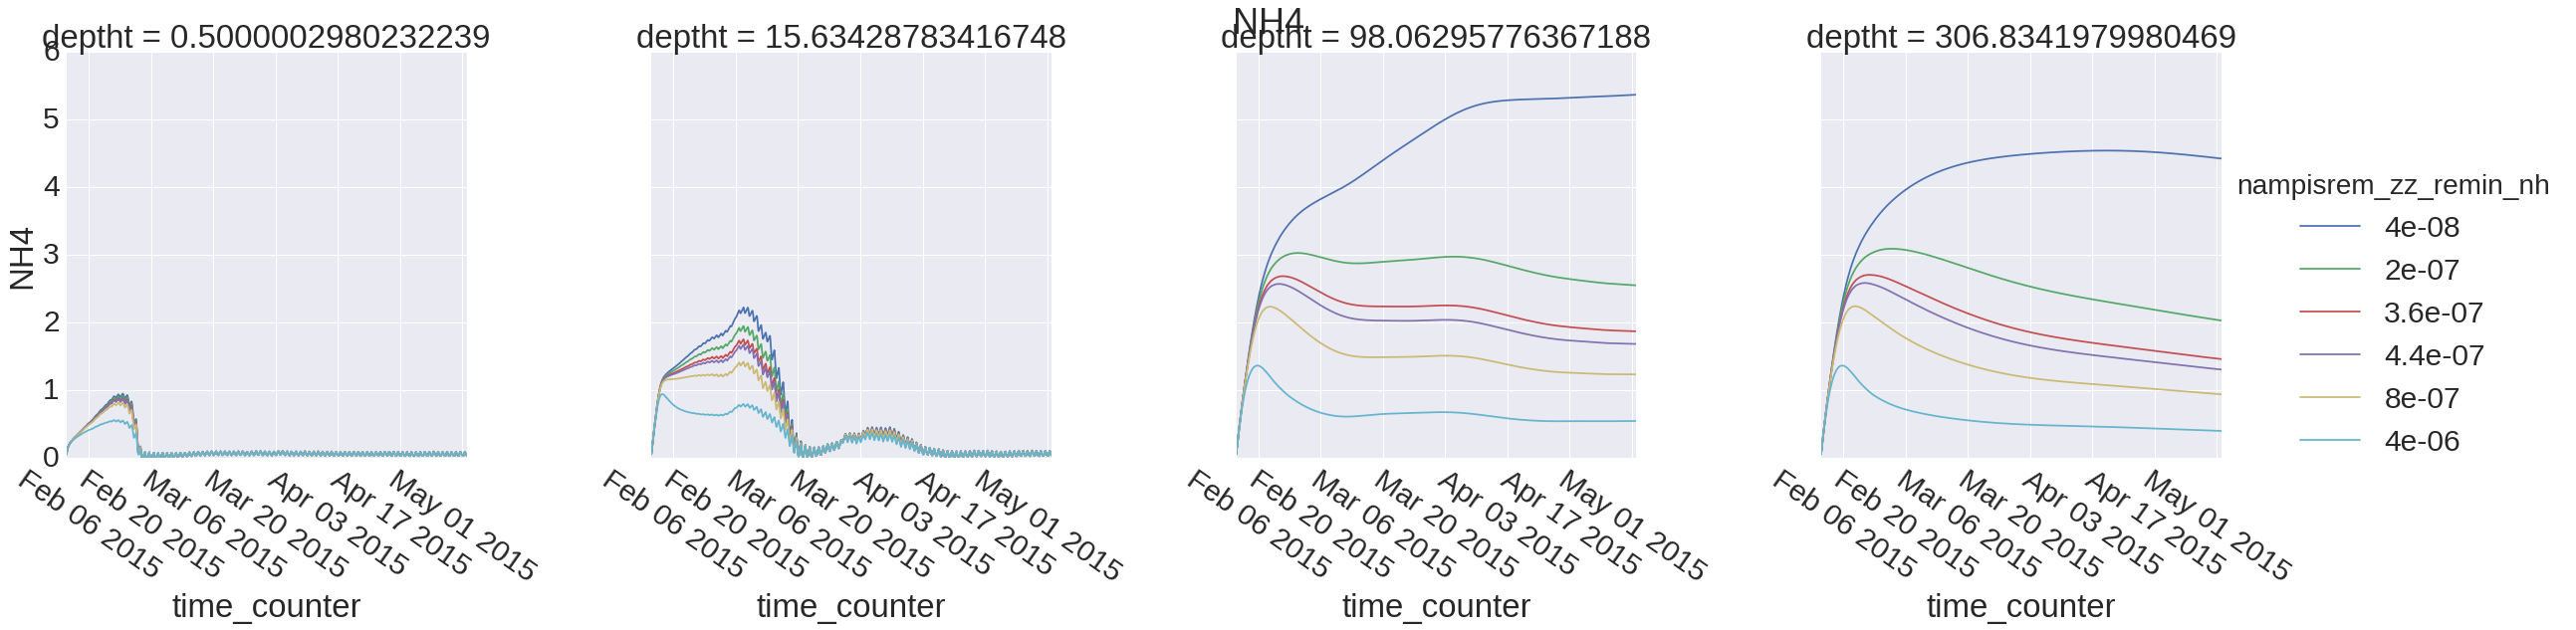

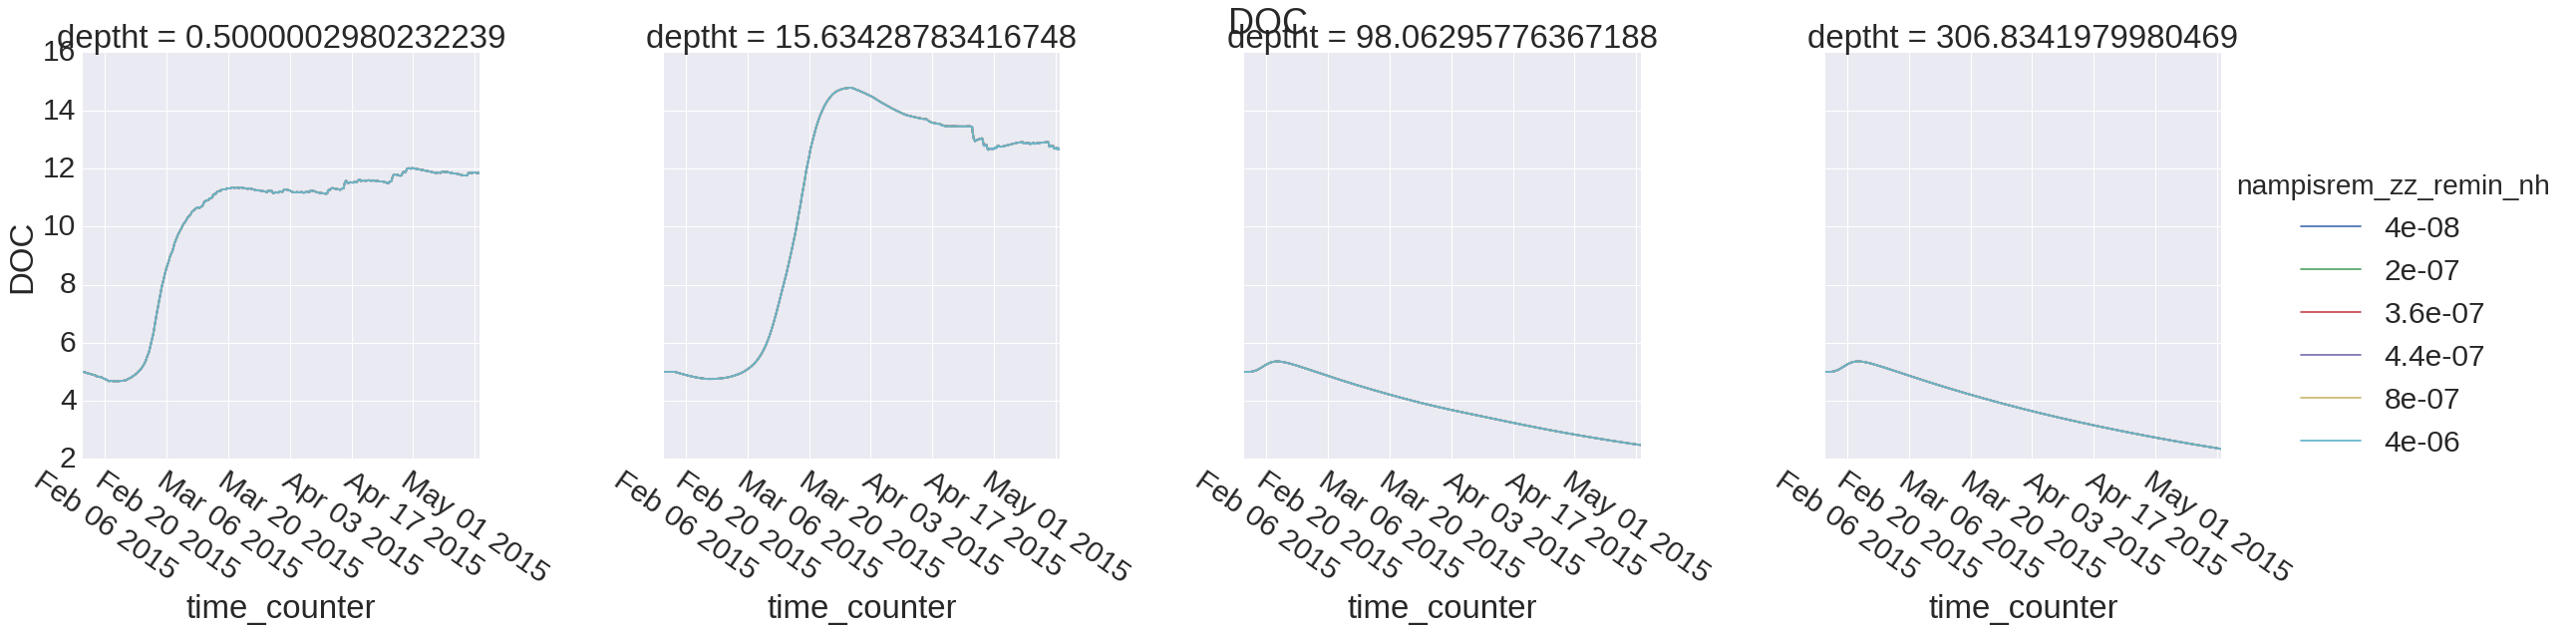

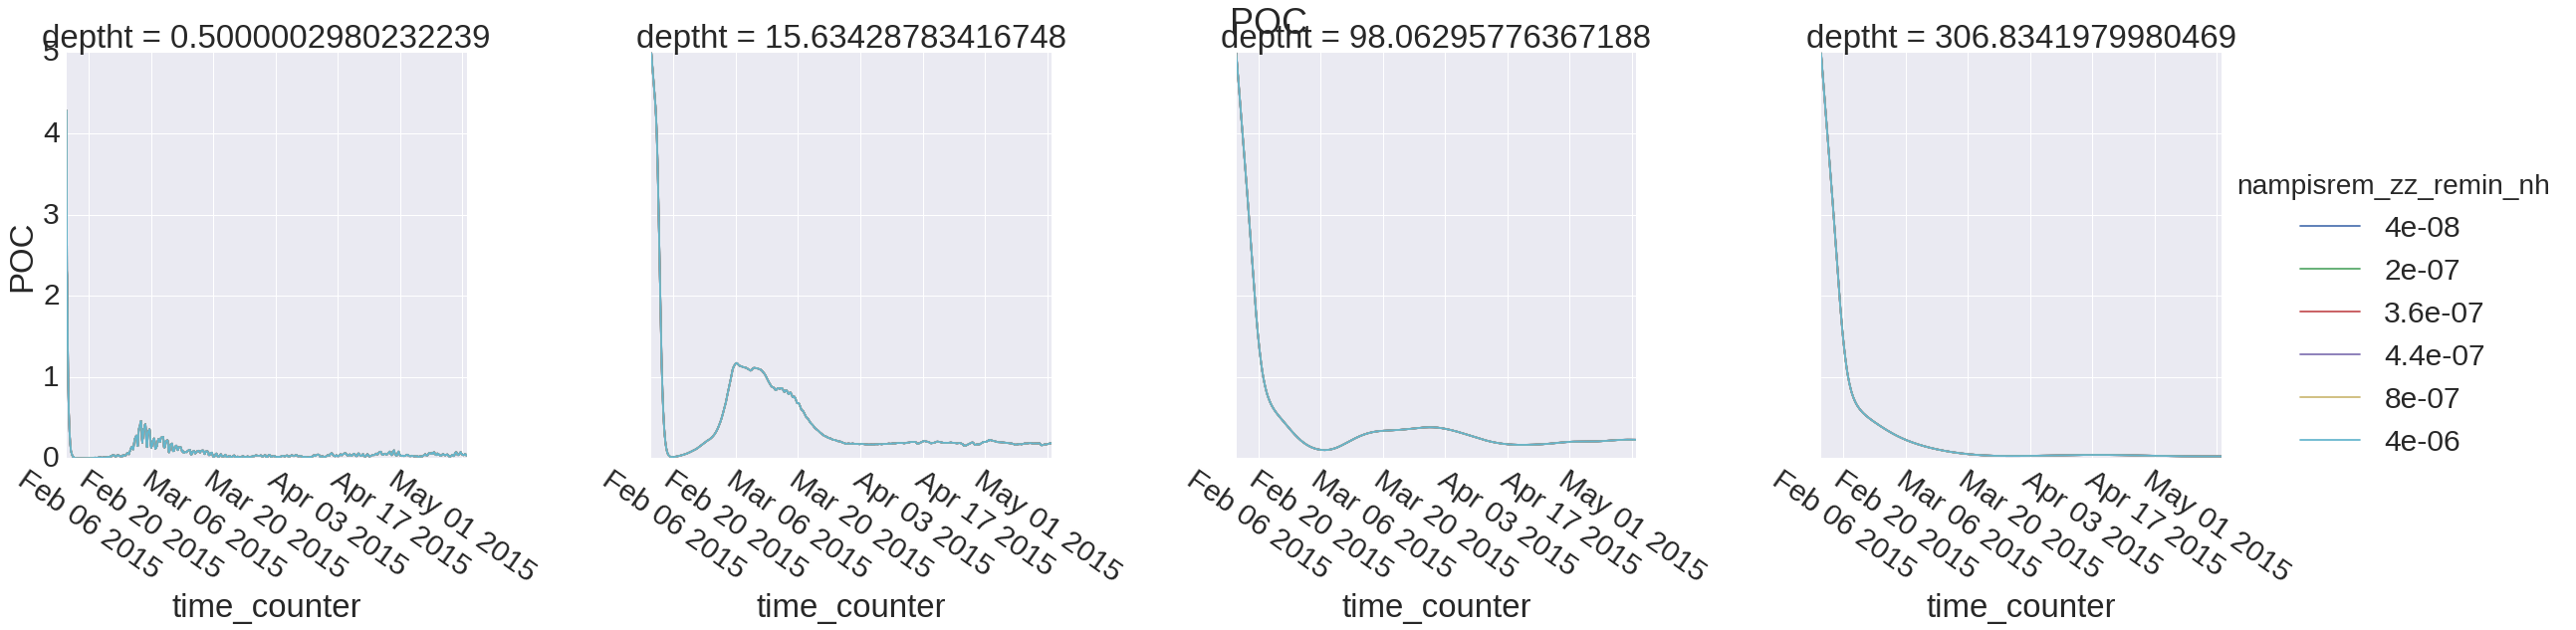

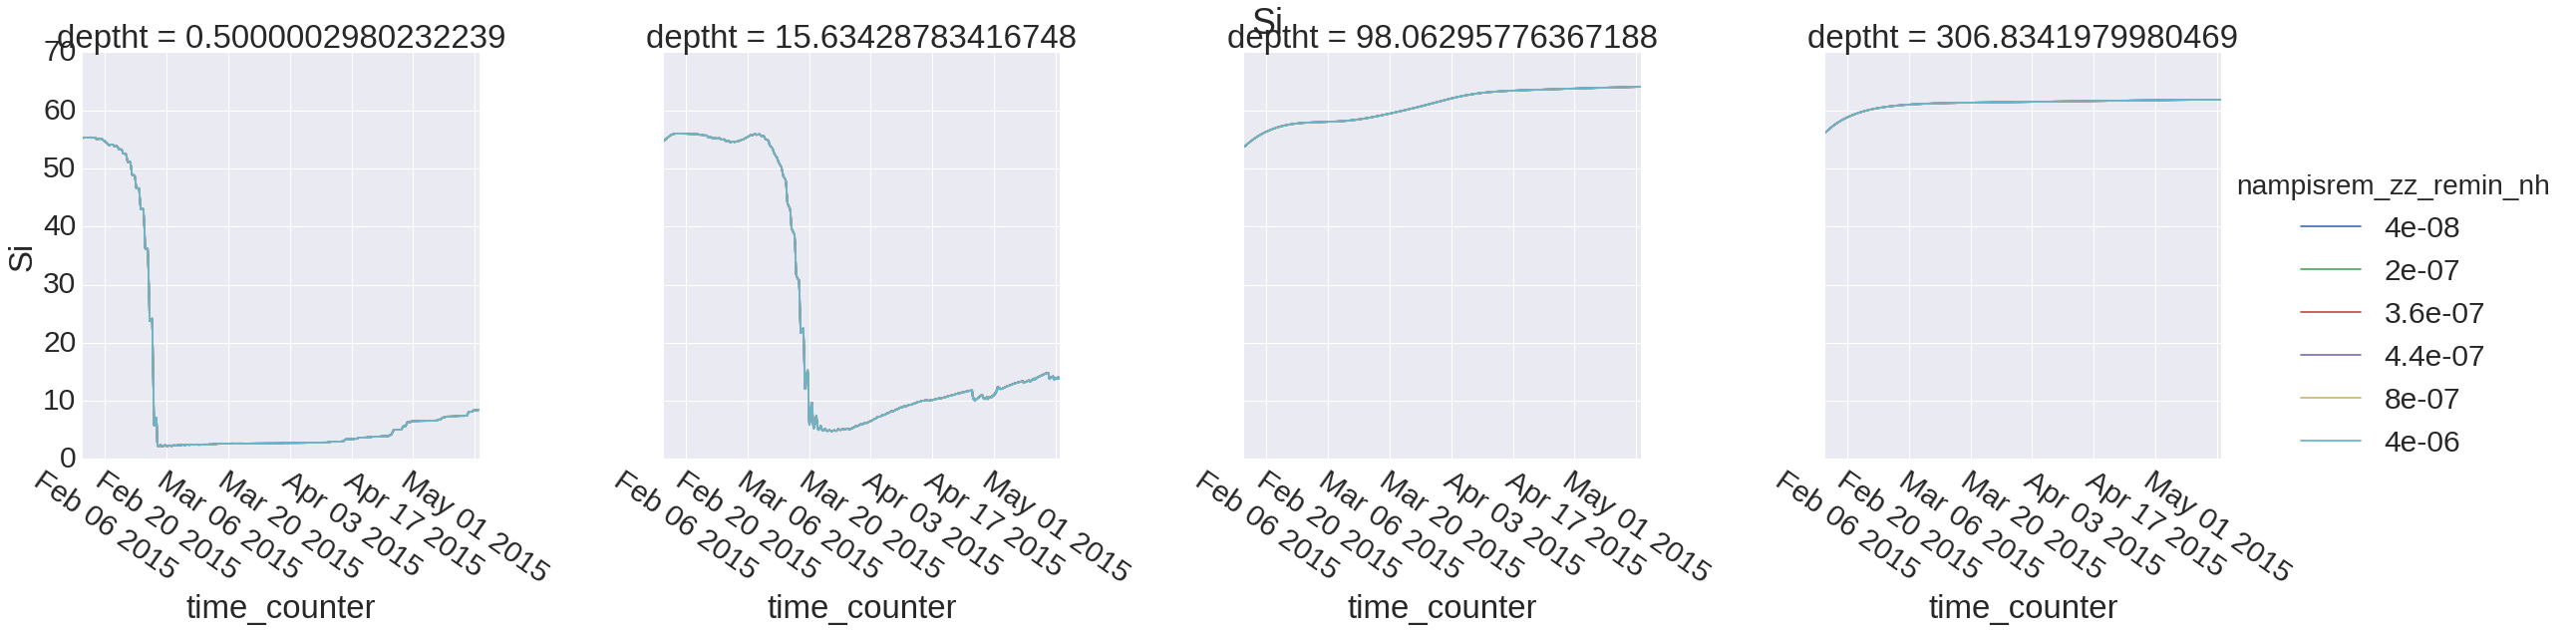

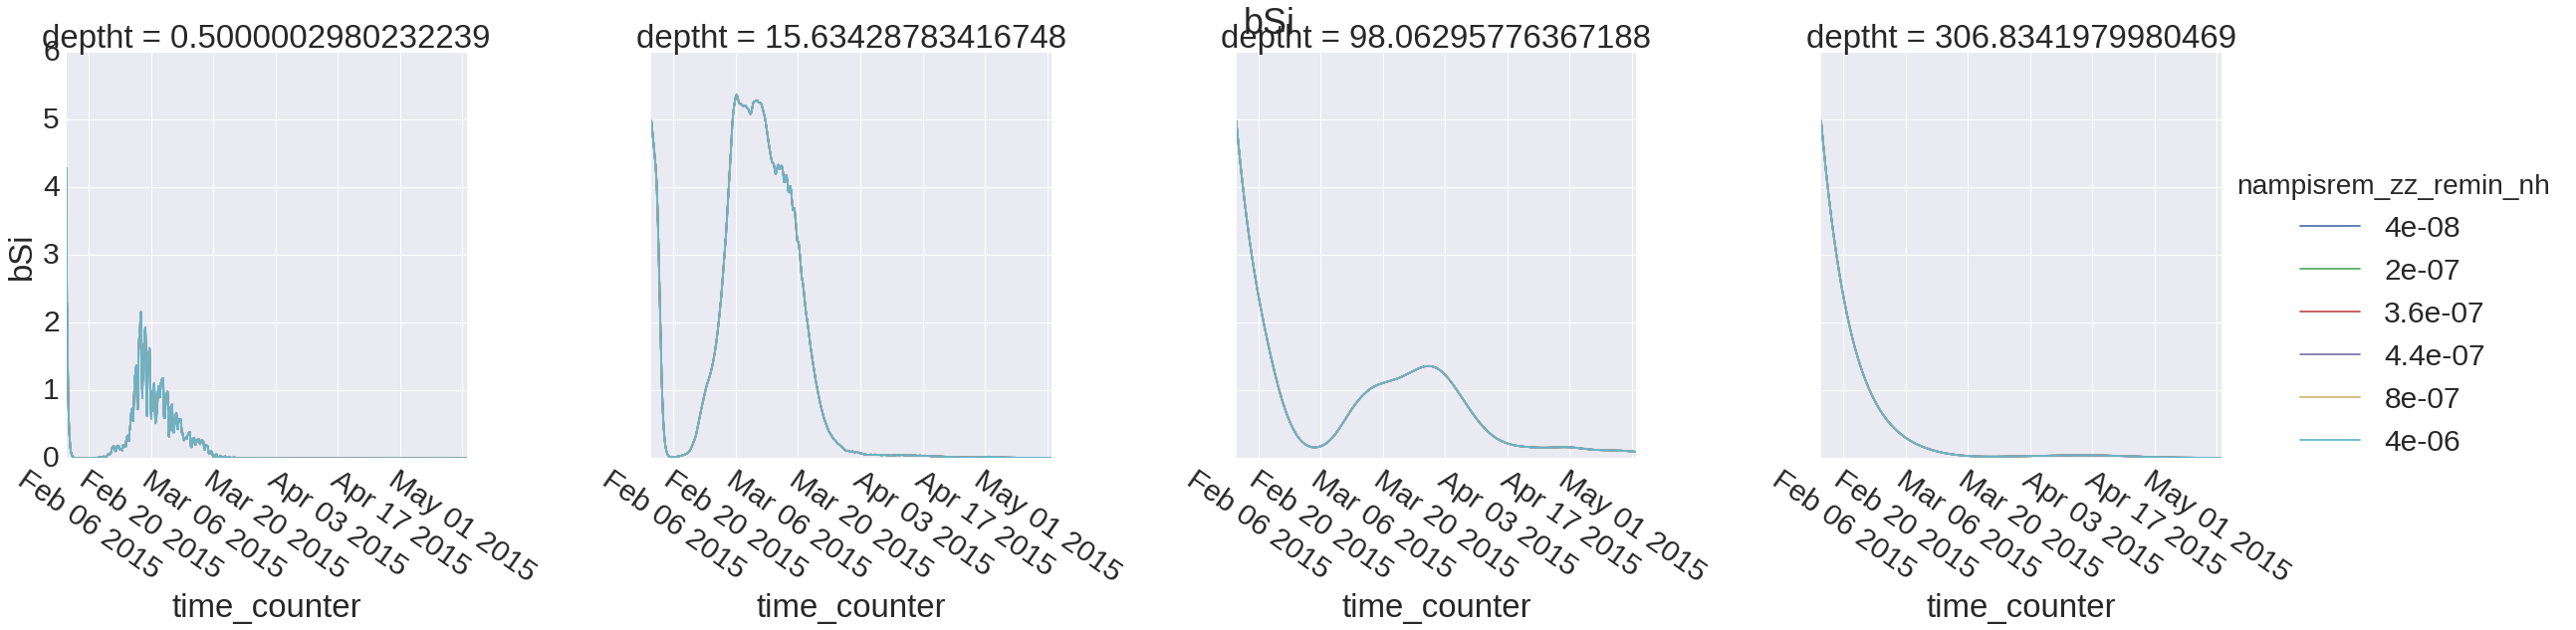

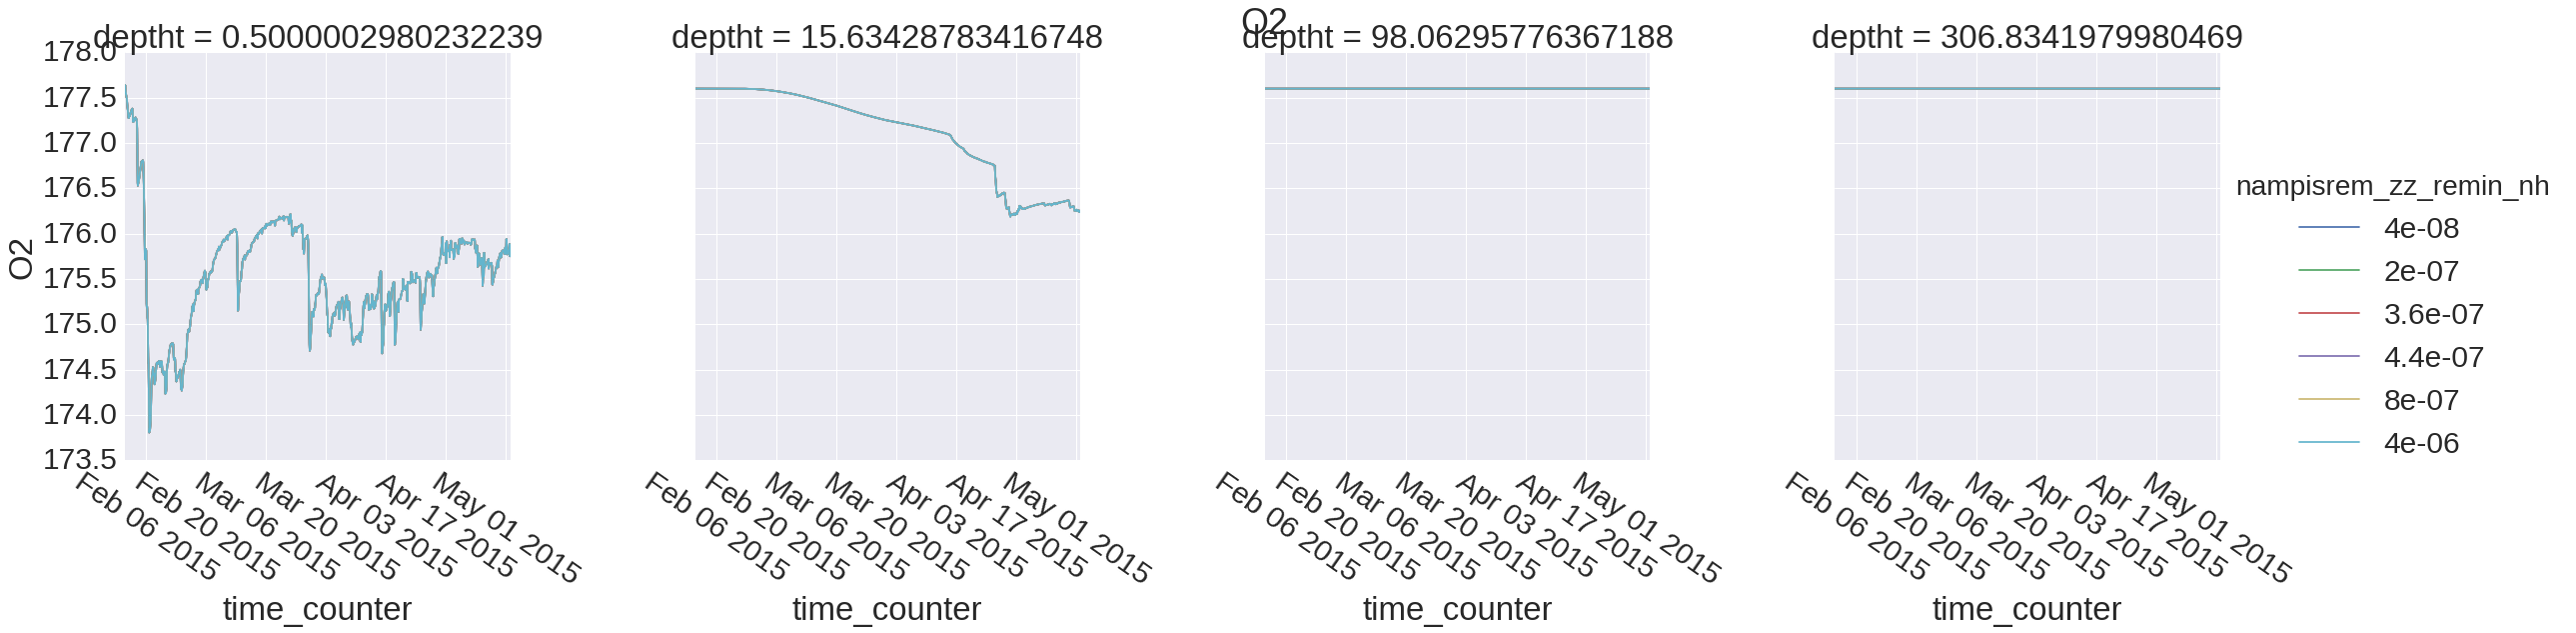

In [12]:
sns.set(font_scale = 3)
plt.rcParams['image.cmap'] = 'jet'

depth_vals = (df_subset['deptht'].unique())[[0,15,26,34]]

print(depth_vals)
for var in plot_vars:
    fg = sns.FacetGrid(data=df_subset.query("deptht in @depth_vals"), hue=param_name,col = "deptht",size = 8)
    fg.map(plt.plot, 'time_counter', var).add_legend()
    fg.set_xticklabels(rotation=-35)
    plt.subplots_adjust(top=0.9)
    fg.fig.suptitle(var)